Questions
- Convergence warning on the year logistic?
- N used main crimecode for his regression...
- What is the meaning of the intercept's p value?
- Can we do a logistic regression with all these variables?
- EDA in tableau and not shown here...
- Statistical question out of streets data.
- How do we use train/test data?
- Clustering idea: if you wanted to categorize areas & times to understand which combinations had the highest need for policing

# Getting and cleaning the data

In [7]:
# Loads the modules
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm
import requests
import json
from statsmodels.formula.api import ols
from statsmodels.formula.api import logit
import datetime
import calendar
from sklearn.cross_validation import train_test_split
from sklearn.cluster import KMeans
%matplotlib inline

In [8]:
# Loads the data
base_url = 'https://raw.githubusercontent.com/aisaacso/SafeBoss/master/'
crime_url = base_url + 'Crime_Incident_Reports.csv'
crime = pd.read_csv(crime_url, low_memory = False)

In [9]:
# Cleans the data

# Converts FROMDATE from str to datetime
crime['FROMDATE'] = pd.to_datetime(crime.FROMDATE, format = '%m/%d/%Y %I:%M:%S %p')

# Lops off data from July, 2012 to August, 2012, so that we have full years (not sure this matters)
crime = crime[crime.FROMDATE > '2012-08-10 00:00:00']

#Add a date column
crime['Date'] = crime.FROMDATE.dt.date

#Add a column for the month name
def mo_as_name(mo):
    return calendar.month_name[mo]

crime['MoName'] =  crime['Month'].map(mo_as_name)

In [10]:
# Dummy for shooting
def shoot_dummy(v):
    if v=='Yes':
        return 1
    else:
        return 0
    
crime['Shooting'] = crime['Shooting'].map(shoot_dummy)

# this doesn't work for some reason...maybe because Shooting is objects, not strings?
#crime['Shoot_dumb'] = crime['Shooting'].map({0:'No', 1:'Yes'})
# eventually, do this inline, like #train_df['alive?'] = train_df['Survived'].map({0:'dead', 1:'alive'}) 

In [11]:
# Prepares weather data for adding to crime data
weather_url = base_url + 'weather.csv'
weather = pd.read_csv(weather_url)
weather = weather[weather.STATION == 'GHCND:USW00014739']
weather['Date'] = pd.to_datetime(weather.DATE, format = '%Y%m%d')
weather['Date'] = weather.Date.dt.date

# Exploratory Analysis
(Still need to do more of this)

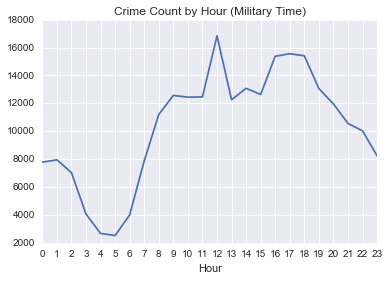

In [12]:
# Analysis of crime time of day

# Overrides a warning that I don't really understand; should look into it more
pd.options.mode.chained_assignment = None

# Adds Hour column for each crime
crime['Hour'] = crime.FROMDATE.dt.hour

# Removes the rows that have no time -- probably needlessly complex!
crime_no_time = crime[(crime.FROMDATE.dt.hour == 0) & (crime.FROMDATE.dt.minute == 0)]
crime_no_time['no_time'] = 'indicator'
crime_time = crime.merge(crime_no_time, how='left')
crime_time = crime_time[crime_time.no_time <> 'indicator']

# Pivot table of count conditioned on hour
hours = pd.pivot_table(crime_time, values = 'DAY_WEEK', index = 'Hour', aggfunc = 'count')

#Plots the total number of crimes at each time of day
hours.plot(xticks = crime.Hour.unique(), title='Crime Count by Hour (Military Time)')

# Regression: What factors contribute to crime per day?

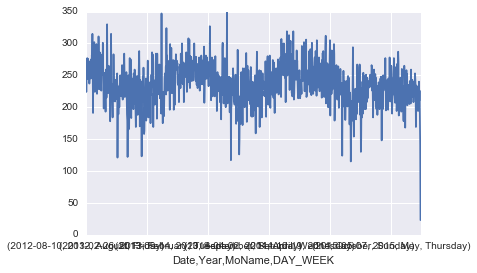

In [21]:
# EDA
dates = pd.pivot_table(crime, values = 'MAIN_CRIMECODE', index = ['Date', 'Year', 'MoName', 'DAY_WEEK'], aggfunc = 'count')
dates.plot()

In [16]:
#Regression
dates = pd.DataFrame(dates)
dates['Date'] = dates.index.get_level_values(0)
dates['Year'] = dates.index.get_level_values(1)
dates['Month'] = dates.index.get_level_values(2)
dates['WeekDay'] = dates.index.get_level_values(3)
add_weather = pd.merge(dates, weather, how = 'outer', on = 'Date')
week_dummies = pd.get_dummies(add_weather['WeekDay']).iloc[:, 1:]
month_dummies = pd.get_dummies(add_weather['Month']).iloc[:, 1:]
dates_dummy_df = add_weather.join([week_dummies, month_dummies])
train, test = train_test_split(dates_dummy_df, test_size = 0.2)
model = ols(data=dates_dummy_df, formula='MAIN_CRIMECODE ~ Monday + Saturday + Sunday + Thursday + Tuesday + Wednesday \
+ August + December + February + January + July + June + March + May + November + October + September\
+ TMAX + PRCP')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         MAIN_CRIMECODE   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     32.58
Date:                Mon, 25 Apr 2016   Prob (F-statistic):           1.91e-92
Time:                        08:11:54   Log-Likelihood:                -5107.5
No. Observations:                1096   AIC:                         1.026e+04
Df Residuals:                    1076   BIC:                         1.036e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    224.1568      6.017     37.255      0.000       212.351   235.963
Monday       -27.0806      2.926     -9.255      0.000       -32.822   -21.339
Saturday     -23.0625      2.915     -7.911      0.000       -28.783   -17.342
Sunday       -49.7001      2.919    -17.028      0.000       -55.427   -43.973
Thursday     -21.9742      2.919     -7.528      0.000       -27.701   -16.247
Tuesday      -26.3224      2.921     -9.010      0.000       -32.055   -20.590
Wednesday    -23.1604      2.920     -7.933      0.000       -28.889   -17.432
August         0.2227      4.373      0.051      0.959        -8.357     8.803
December      -5.0405      4.018     -1.254      0.210       -12.925     2.844
February       1.7327      4.431      0.391      0.696        -6.962    10.428
January        1.8273      4.249      0.430      0.667        -6.510    10.165
July          -1.3267      4.512     -0.294      0.769       -10.181     7.527
June           3.8203      4.239      0.901      0.368        -4.498    12.139
March          5.9447      4.029      1.476      0.140        -1.960    13.850
May            9.7506      3.986      2.446      0.015         1.930    17.572
November      -2.0692      3.898     -0.531      0.596        -9.717     5.579
October        8.6743      3.870      2.241      0.025         1.081    16.268
September     15.3790      4.134      3.720      0.000         7.268    23.490
TMAX           0.5988      0.091      6.605      0.000         0.421     0.777
PRCP         -10.9752      2.619     -4.191      0.000       -16.113    -5.837
==============================================================================
Omnibus:                      271.151   Durbin-Watson:                   1.379
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2323.164
Skew:                          -0.886   Prob(JB):                         0.00
Kurtosis:                       9.909   Cond. No.                         782.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# P-test: Do some areas have more crimes than others?

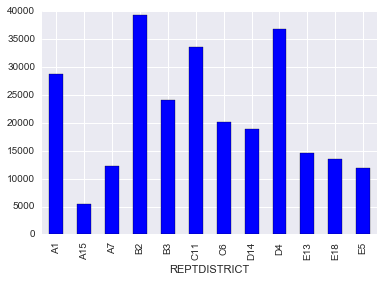

In [24]:
# EDA: Shows which districts have the most crime
crime_no_HTU = crime[crime.REPTDISTRICT <> 'HTU']
reptd = pd.pivot_table(crime_no_HTU, values = 'DAY_WEEK', index = 'REPTDISTRICT', aggfunc = 'count')
reptd.plot(kind = 'bar', sort_columns = True)

# Regression: Given a crime, what factors contribute to crime including a shooting?

## Theory 1: Day of the week

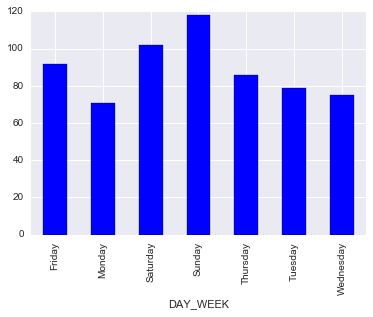

In [22]:
# Shows which days have the most shootings
shootz = crime[crime.Shooting==1]
days = pd.pivot_table(shootz, values = 'COMPNOS', index = 'DAY_WEEK', aggfunc = 'count')
days.plot(kind = 'bar')

In [25]:
# Data prep
# Add dummies; merge with weather; create working data set
week_dummies = pd.get_dummies(crime['DAY_WEEK']).iloc[:, 1:]
month_dummies = pd.get_dummies(crime['MoName']).iloc[:, 1:]
dist_dummies = pd.get_dummies(crime['REPTDISTRICT']).iloc[:,1:]
shift_dummies = pd.get_dummies(crime['SHIFT']).iloc[:,1:]
crtype_dummies = pd.get_dummies(crime['MAIN_CRIMECODE']).iloc[:,1:]
with_weather = pd.merge(crime, weather, how = 'outer', on = 'Date')
dummy_df = with_weather.join([week_dummies, month_dummies, dist_dummies, shift_dummies, crtype_dummies])

In [27]:
# Add year to model? NO
train, test = train_test_split(dummy_df, test_size = 0.2)
model_logistic = logit(data=train, formula='Shooting ~ Year')
result_logistic = model_logistic.fit()

# This will demonstrate that p value isn't high enough to justify inclusion
#result_logistic.summary()
# Is the convergence warning telling me that I don't have enough data? I only have 3 years.

         Current function value: 0.017836
         Iterations: 35


/Users/annaisaacson/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


## Shootings linear regression

In [ ]:
# removed variables: HTU, E13, Tuesday, C11, + September + B2 + A15 + Saturday + + E5 + Sunday  + May + July + January 
model = ols(data=dummy_df, formula='Shooting ~ Monday + Thursday + Wednesday \
+ August + December + February + June + March + November + October \
+ TMAX + PRCP + A7  + B3  + C6 + D14 + D4  + E18')
result = model.fit()
result.summary()
p = result.pvalues
p.sort_values(inplace=True)
print result.rsquared
print p

## Shootings logistic regression

In [39]:
# removed values: + A15 + September + B2 + E13 + Saturday + HTU + January + C11 + E5 + C6 
# Regression
model_logistic = logit(data=train, formula='Shooting ~ Monday + Sunday + Thursday + Tuesday + Wednesday \
+ August + December + February + July + June + March + May + November + October \
+ TMAX + PRCP + A7 + B3 + D14 + D4 + E18 ' 
                     )
result_logistic = model_logistic.fit()

def analyze_p(res):
    p = res.pvalues
    p.sort_values(inplace = True)
    print res.prsquared
    print p
    
#analyze_p(result_logistic)
result_logistic.summary()

Optimization terminated successfully.
         Current function value: 0.017470
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Shooting   No. Observations:               200969
Model:                          Logit   Df Residuals:                   200947
Method:                           MLE   Df Model:                           21
Date:                Mon, 25 Apr 2016   Pseudo R-squ.:                 0.01141
Time:                        08:38:15   Log-Likelihood:                -3510.9
converged:                       True   LL-Null:                       -3551.4
                                        LLR p-value:                 5.403e-09
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -7.3040      0.296    -24.701      0.000        -7.884    -6.724
Monday         0.4129      0.139      2.975      0.003         0.141     0.685
Sunday         0.1679      0.155      1.086      0.278        -0.135     0.471
Thursday       0.3735      0.139      2.681      0.007         0.100     0.646
Tuesday        0.1563      0.151      1.037      0.300        -0.139     0.452
Wednesday      0.2190      0.146      1.498      0.134        -0.068     0.506
August         0.3118      0.180      1.736      0.083        -0.040     0.664
December       0.5996      0.217      2.767      0.006         0.175     1.024
February       0.3729      0.214      1.744      0.081        -0.046     0.792
July           0.3146      0.197      1.595      0.111        -0.072     0.701
June           0.3416      0.188      1.813      0.070        -0.028     0.711
March          0.4416      0.177      2.501      0.012         0.096     0.788
May            0.2706      0.184      1.469      0.142        -0.090     0.632
November       0.3444      0.227      1.519      0.129        -0.100     0.789
October        0.3330      0.194      1.713      0.087        -0.048     0.714
TMAX           0.0160      0.004      3.713      0.000         0.008     0.024
PRCP          -0.4039      0.202     -2.001      0.045        -0.800    -0.008
A7            -0.3366      0.236     -1.426      0.154        -0.799     0.126
B3            -0.2734      0.167     -1.632      0.103        -0.602     0.055
D14           -0.1607      0.178     -0.903      0.366        -0.509     0.188
D4            -0.2436      0.137     -1.772      0.076        -0.513     0.026
E18           -0.6084      0.256     -2.375      0.018        -1.110    -0.106
==============================================================================
"""

In [ ]:
residuals = result_logistic.resid_dev
fig = sns.distplot(residuals)

# Kmeans: Do certain kinds of common crimes happen in certain neighborhoods?

In [127]:
# Data wrangling

# Find the most common crime types
cr_counts = pd.DataFrame(pd.pivot_table(crime, index = 'MAIN_CRIMECODE', values = 'DAY_WEEK', aggfunc = 'count'))
cr_counts.sort_values('DAY_WEEK', ascending = False, inplace = True)
cr_counts = cr_counts.head(10)
top_crimes = cr_counts.index.tolist()

# Prep the data
districts = dist_dummies.columns.tolist()
combined = ['REPTDISTRICT'] + top_crimes
class_data = dummy_df[combined].dropna()

list

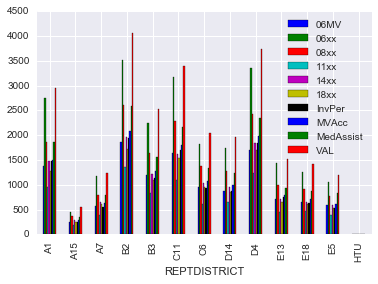

In [129]:
# EDA
districts_crimes = pd.pivot_table(class_data, index = 'REPTDISTRICT', values = crime_types, aggfunc = 'sum')
districts_crimes.plot(kind = 'bar')

In [130]:
# Build the model
model = KMeans( n_clusters =  len(districts))
model = model.fit(class_data.iloc[:,1:])
class_data['kmeans_class'] = model.labels_

kmeans_class,0,1,2,3,4,5,6,7,8,9,11
REPTDISTRICT,,,,,,,,,,,
A1,10382,1860,2945,1488,2751,1863,1492,1472,1381,1280,961
A15,2025,356,554,290,461,365,299,257,259,246,199
A7,4489,798,1245,650,1188,788,640,554,575,606,383
B2,14323,2595,4058,1974,3512,2606,2091,1952,1869,1714,1351
B3,8672,1551,2534,1209,2239,1637,1278,1128,1199,1091,844
C11,12116,2175,3401,1626,3173,2282,1794,1707,1636,1532,1095
C6,7240,1332,2040,1032,1821,1376,1075,934,956,951,612
D14,6764,1231,1968,954,1752,1274,990,881,882,861,654
D4,13366,2341,3745,1835,3354,2434,1977,1849,1704,1695,1230


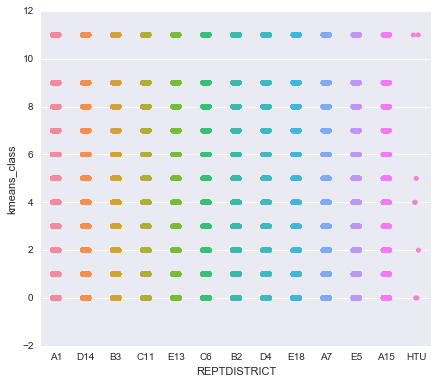

In [134]:
# Analyze the model

#Plot the classification
plt.figure(figsize=(7,6))
sns.stripplot(x='REPTDISTRICT', y='kmeans_class', data=class_data, jitter= True)

#Confusion matrix
pd.pivot_table(class_data, index='REPTDISTRICT', columns = 'kmeans_class', values = '11xx', aggfunc = 'count')

# Kmeans: Do certain kinds of crimes happen on certain police shifts?

# Crimes of business concern
Team: The charts below show the streets with the most business crimes for each district.
How do we want to go about turning this into a statistics question?

In [ ]:
# create a pivot table that classifies streets by the number of business crimes

business_crimes = ['COMMERCIAL BURGLARY', 'VANDALISM', 'ROBBERY', 'OTHER LARCENY', 'BurgTools', 'ARSON', 'Larceny'\
                  'Other Burglary', 'PROSTITUTION CHARGES', 'PubDrink']

def is_bus_cr(c):
    if c in business_crimes:
        return 1
    else:
        return 0
    
crime['BusCr'] =  crime['INCIDENT_TYPE_DESCRIPTION'].map(is_bus_cr)
dists = crime['REPTDISTRICT'].unique().tolist()

#Removes NaN; will only work if nan is the last one.
dists.pop()

for d in dists:
    var = crime.loc[crime.REPTDISTRICT == d]
    streets = pd.DataFrame(pd.pivot_table(var, values = 'BusCr', index = 'STREETNAME', aggfunc = 'sum'))
    streets.sort_values('BusCr', ascending = False, inplace = True)
    top_five = streets.head(5)
    top_five.plot(kind = 'bar', title = d)
    #total = streets.BusCr.sum()
    #top_five['Proportion_here'] = top_five.BusCr / total